In [195]:
#first i need data from a previous run
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, metrics, Model
from tensorflow.keras.callbacks import Callback
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py
import datetime
from scipy.optimize import curve_fit
import math
from scipy import asarray as ar,exp
import pylab as plb
import tqdm
from tqdm import tqdm
import time
import progressbar

In [146]:
dataset = h5py.File('simu_HDF_thistimeforReal.h5', 'r') #load data
num_diodes = dataset['Num_diodes'][...] #separate the data into each key within the data file
x_pos = (dataset['Xpos'][...])/100
y_pos = (dataset['Ypos'][...])/100
histgrid = dataset['histgrid'][...]
histgrid = histgrid[:-10,:,:] #redefine the shape and size of histgrid by removing the last 10 events
output = np.vstack((x_pos,y_pos)) #define new, single variable for x and y position
output = np.transpose(output) #original definition was sideways, so we transposed it

where_are_NaNs = isnan(histgrid) #removes any NaN values within histgrid; shouldn't be a problem with bad values removed
histgrid[where_are_NaNs] = 0

print(histgrid.shape)

dataset.close()

(991, 342, 132)


In [147]:
def data_compile(histdata):
    data = []  #creates empty arrays for data and labels
    labels = []
    for i in range(histdata.shape[1]):
        for j in range(0,histdata.shape[0]):
            data.append(histdata[j,i,:]) #puts histgrid data inside of "data"
            labels.append(output[i]) #puts x,y _pos into "labels"
    return(np.array(data),np.array(labels))

all_data, all_labels = data_compile(histgrid)

#to make sure everything is the correct shape
print(all_data.shape)
print(all_labels.shape)

(338922, 132)
(338922, 2)


In [148]:
all_data = normalize(all_data,axis = 1)
print(np.max(all_data))

0.8395246220687987


In [149]:
#define all_labels and all_data as df's to better view rows and add column
all_labels = pd.DataFrame(all_labels)
all_data = pd.DataFrame(all_data)
all_data["sum"] = np.sum(all_data, axis = 1) #column added to find rows with only 0's

#confirming number of initial entries
print(len(all_labels))
print(len(all_data))

#find all the locations in all_data (by index) where the only values are 0 across the diodes
remove_labels = list(all_data[all_data["sum"] == 0].index)
print(len(remove_labels))

#added these to ensure I have unshuffled versions of the data and labels for finding locations with larger error
unshuf_labels = all_labels.drop(all_labels.index[remove_labels])
unshuf_data = all_data[all_data["sum"] != 0]

#lets all_labels and all_data start with the same indices and values as their unshuffled counterparts
all_labels = unshuf_labels
unshuf_labels = unshuf_labels.to_numpy() #dfs are hard to graph with, so I converted to np.arrays for future use
all_data = unshuf_data
unshuf_data = unshuf_data.to_numpy()

#confirm new number of entries (should be len(remove_labels) less than the intital value)
print(len(all_labels))
print(len(all_data))

#must remove the sum column before using in FCNN; otherwise it will treat it as a data point 
del all_data['sum']

338922
338922
286
338636
338636


In [150]:
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2,shuffle=True)
#splits training and test data for the FCNN; 20% set aside for testing

In [151]:
#early stopping mechanism; can increase amount of time before stopping by increasing patience
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [152]:
#Fully connected neural network
#the "layers" are the dense hidden layers which are fully connected
#first number changes the nodes, 2nd is the activation function, (first line has number of inputs as well)

FCNN_model = tf.keras.Sequential()
FCNN_model.add(layers.Dense(256, activation='relu', input_shape = [132]))
FCNN_model.add(layers.Dense(256, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dense(128, activation = 'relu'))
#FCNN_model.add(layers.Dropout(0.2))
FCNN_model.add(layers.Dense(2, activation = 'linear'))

In [153]:
#compiles the FCNN and includes the learning rate as well
FCNN_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss = 'mse', 
              metrics=['mae', 'mse'])

In [154]:
FCNN_history = FCNN_model.fit(train_data, train_labels,
                    epochs=60,
                    batch_size = 32,
                    #callbacks = [callback],
                    validation_split = 0.3 
                    )

Epoch 1/60
5927/5927 [==============================] - 44s 7ms/step - loss: 4.5590 - mae: 0.6864 - mse: 4.5590 - val_loss: 0.2602 - val_mae: 0.3979 - val_mse: 0.2602
Epoch 2/60
5927/5927 [==============================] - 39s 7ms/step - loss: 0.1783 - mae: 0.3242 - mse: 0.1783 - val_loss: 0.1240 - val_mae: 0.2781 - val_mse: 0.1240
Epoch 3/60
5927/5927 [==============================] - 47s 8ms/step - loss: 0.1119 - mae: 0.2590 - mse: 0.1119 - val_loss: 0.1125 - val_mae: 0.2636 - val_mse: 0.1125
Epoch 4/60
5927/5927 [==============================] - 38s 6ms/step - loss: 0.0827 - mae: 0.2231 - mse: 0.0827 - val_loss: 0.0818 - val_mae: 0.2258 - val_mse: 0.0818
Epoch 5/60
5927/5927 [==============================] - 49s 8ms/step - loss: 0.0670 - mae: 0.2004 - mse: 0.0670 - val_loss: 0.0467 - val_mae: 0.1720 - val_mse: 0.0467
Epoch 6/60
5927/5927 [==============================] - 33s 6ms/step - loss: 0.0539 - mae: 0.1800 - mse: 0.0539 - val_loss: 0.0690 - val_mae: 0.2089 - val_mse: 0.069

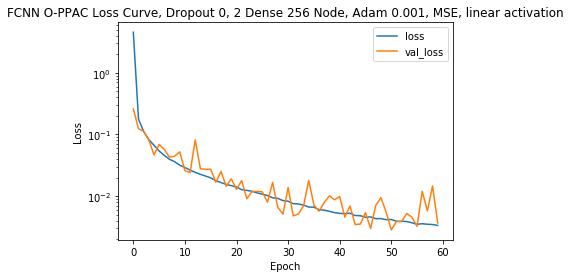

2117/2117 - 7s - loss: 0.0042 - mae: 0.0425 - mse: 0.0042


In [155]:
#loss plot of training and test data
plt.plot(FCNN_history.history['loss'], label='loss')
plt.plot(FCNN_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title("FCNN O-PPAC Loss Curve, Dropout 0, 2 Dense 256 Node, Adam 0.001, MSE, linear activation")
plt.show()

#separation of 'result' values (stats from test data)
result = FCNN_model.evaluate(test_data, test_labels, verbose=2)

#separation of 'prediction' values (training data)
predictions = FCNN_model.predict(test_data)

In [298]:
#separates x and y predicted values so there can be separate graphs for each
x_pred = predictions[:,0]
y_pred = predictions[:,1]


x_test1 = test_labels[0]
y_test1 = test_labels[1]

#converts to np.arrays for graphing
x_test = np.array(x_test1)
y_test = np.array(y_test1)

x_test[0]
y_test[0]

<class 'pandas.core.frame.DataFrame'>


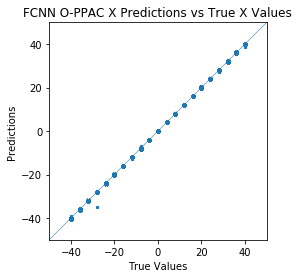

In [157]:
#graph showing the accuracy of FCNN model by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels = []
for i in range(x_test.shape[0]):
    new_x_labels.append([x_test[i]])
np.array(new_x_labels)
new_x_labels[2]

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels, x_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC X Predictions vs True X Values")
plt.show()

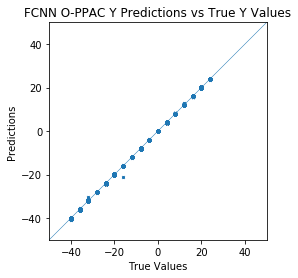

In [158]:
#graph showing the accuracy of FCNN model by comparing predicted and true y values
#should be as close to the diagonal as possible
new_y_labels = []
for i in range(y_test.shape[0]):
    new_y_labels.append([y_test[i]])
np.array(new_y_labels)
new_y_labels[2]

a = plt.axes(aspect='equal')
plt.scatter(new_y_labels, y_pred, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("FCNN O-PPAC Y Predictions vs True Y Values")
plt.show()

In [159]:
#to find the locations of largest error within my predicted x values
x_error = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
xerror_list = [i for i in x_error if abs(i) >= 1]
xerror_list.sort(reverse = True)
print(len(xerror_list))
print(xerror_list)

2
[-1.3194618225097656, -6.698822021484375]


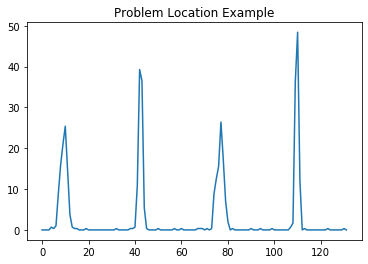

[67]


In [297]:
#graph the location of areas with larger x-error; uses unshuffled data from above
bad_xvalue = -6.698822021484375
x_test_locat = x_error.index(bad_xvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[x_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[x_error.index(bad_xvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[x_error.index(bad_xvalue)])))

print(np.intersect1d(x_locat, y_locat))

In [283]:
#to find the locations of largest error within my predicted y values (same as the x code above but specific to y)
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

yerror_list = [i for i in y_error if abs(i) >= 1]
yerror_list.sort(reverse = True)
print(len(yerror_list))
print(yerror_list)

2
[1.818166732788086, -5.221246719360352]


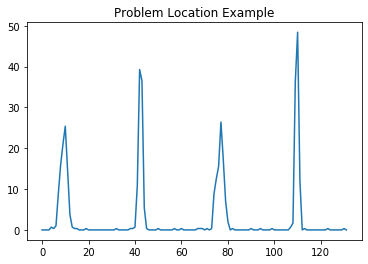

[67]


In [284]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_yvalue = -5.221246719360352
y_test_locat = y_error.index(bad_yvalue)

plt.title('Problem Location Example')
plt.plot(unshuf_data[y_test_locat][:-1]*100)
plt.show()

#prints event index within histgrid
x_locat = np.where(x_pos == (np.array(x_test[y_error.index(bad_yvalue)])))
y_locat = np.where(y_pos == (np.array(y_test[y_error.index(bad_yvalue)])))

print(np.intersect1d(x_locat, y_locat))

67726


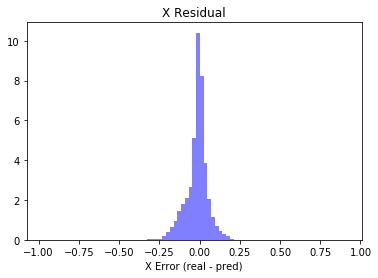

2.6647567749023438


In [272]:
#residue plot of x-error from the FCNN model
x_error = []

for i in range(x_pred.shape[0]):
    x_error_test = x_pred[i] - x_test[i]
    x_error.append(x_error_test)

error_list_x = [i for i in x_error if abs(i) <= 1]
print(len(error_list_x))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')
plt.title(r'X Residual')
plt.show()


#calculate percent error
x_abs_error = []
for i in range(x_pred.shape[0]):
    x_abs_error_test = abs(x_pred[i] - x_test[i])
    x_abs_error.append(x_error_test)
    
x_perc_error = abs((sum(x_abs_error)/len(x_abs_error))*100)
print(x_perc_error)

67726


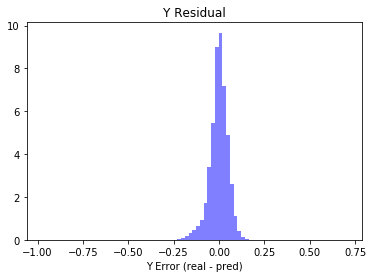

3.3594131469726562


In [269]:
#residue plot of y-error from the FCNN model
y_error = []

for i in range(y_pred.shape[0]):
    y_error_test = y_pred[i] - y_test[i]
    y_error.append(y_error_test)

error_list_y = [i for i in y_error if abs(i) <= 1]
print(len(error_list_y))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_y, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('Y Error (real - pred)')
plt.title(r'Y Residual')
plt.show()



#percent error calculation
y_abs_error = []
for i in range(y_pred.shape[0]):
    y_abs_error_test = abs(y_pred[i] - y_test[i])
    y_abs_error.append(y_error_test)
y_perc_error = (sum(y_abs_error)/len(y_abs_error))*100
print(y_perc_error)

In [ ]:
#now to look at the data via the Gaussian model to check for better accuracy

In [165]:
#separate original unshuffled data into the 4 sides (each side has 33 diodes)
x1_data = (unshuf_data[:, :33])*100
x2_data = (unshuf_data[:, 33:66])*100
y1_data = (unshuf_data[:, 66:99])*100
y2_data = (unshuf_data[:, 99:132])*100

#make sure the labels and data have the same indices by also using unshuffled labels
x_label = unshuf_labels[ : , 0 ]
y_label = unshuf_labels[ : , 1 ]

print(x1_data.shape)
print(x_label.shape)

print(np.min(x1_data))

(338636, 33)
(338636,)
0.0


In [166]:
#turn the test_data and test_labels dfs into arrays  to work with them easily
test_data_arr = test_data.to_numpy()
test_labels_arr = test_labels.to_numpy()

#separate the test data as done above; used so that it is the same sample as the FCNN
x1_data_test = (test_data_arr[: , :33])*100
x2_data_test = (test_data_arr[:, 33:66])*100
y1_data_test = (test_data_arr[:, 66:99])*100
y2_data_test = (test_data_arr[:, 99:132])*100

#labels kept so they have the same indices
x_label_test = test_labels_arr[ : , 0 ]
y_label_test = test_labels_arr[ : , 1 ]

print(x1_data.shape)
print(x_label.shape)

print(np.min(x1_data))

(338636, 33)
(338636,)
0.0


In [41]:
#https://stackoverflow.com/questions/19206332/gaussian-fit-for-python

In [167]:
#basic gaussian fit stuff; needs x and y inputs for all data points; index is both for the y data and for lower code
index = 45
x = np.arange(0,33,1)
y = x1_data_test[index,:]

In [168]:
#gaussian fit function
def func(x, k, sigma, mu):
    return k*np.exp(-(x-mu)**2/(2*sigma**2))

In [173]:
#curve fit code; bounds might be able to be played with still to improve model (specifically sigma in index 1)
popt, _ = curve_fit(func, x, y, bounds=(0, [33.,7., 33.]))
popt

array([30.84280187,  1.3597756 ,  6.69024628])

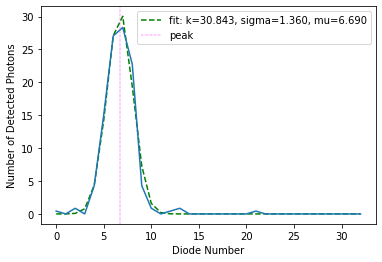

In [174]:
#plotting gaussian to make sure it looks logically correct
plt.plot(x, func(x, *popt), 'g--', label='fit: k=%5.3f, sigma=%5.3f, mu=%5.3f' % tuple(popt))
plt.plot(x1_data_test[index,:])
plt.axvline(x = popt[2], color = "magenta", linewidth=.4, linestyle='dashdot', label='peak')
plt.xlabel('Diode Number')
plt.ylabel('Number of Detected Photons')
plt.legend()
plt.show()

In [273]:
#same gaussian function as below, just reused so everything is in one place
def func(x, a, sigma, x0):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#function to (hopefully) fit gaussians (and thus, centroids which is what we want) onto all data sets
def centroidmm(x, y):
    popt, _ = curve_fit(func, x, y, bounds=(0, [33., 20., 33.]))
    return (popt[2]/33)*100-48 #converts location from diode number to mm (measurement of x_pos & y_pos)

#conversion and calculation + creation of centroid location array for all of the side x1    
x1_peaks = []
for i in range(x1_data_test.shape[0]):
    x1_mm = centroidmm(np.arange(0,33,1), x1_data_test[i,:])
    x1_peaks.append(x1_mm)
    
#been taking a long time to load even with cluster

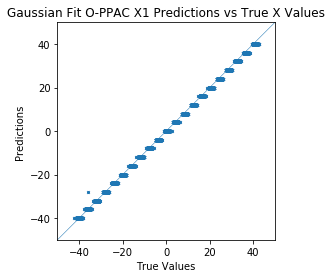

67727


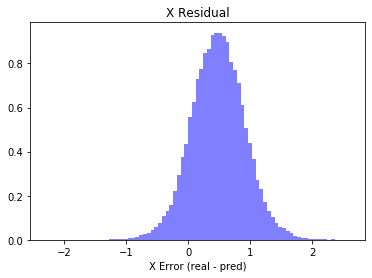

53.50251977021294


In [275]:
x1_peaks = np.array(x1_peaks)

new_x1_labels_g = []
for i in range(x1_peaks.shape[0]):
    new_x1_labels_g.append(x1_peaks[i])
np.array(new_x1_labels_g)

a = plt.axes(aspect='equal')

plt.scatter(new_x1_labels_g, x_label_test, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC X1 Predictions vs True X Values")
plt.show()

x1_error_g = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x1_peaks.shape[0]):
    x1_error_test_g = x1_peaks[i] - x_label_test[i]
    x1_error_g.append(x1_error_test_g)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
error_list_x1_g = [i for i in x1_error_g if abs(i) <= 5]
print(len(error_list_x1_g))

num_bins_x = 81
# the histogram of the data
n, bins, patches = plt.hist(error_list_x1_g, num_bins_x, density=1, facecolor='blue', alpha=0.5)

plt.xlabel('X Error (real - pred)')
plt.title(r'X Residual')
plt.show()

#percent error calculation
x1_abs_error = []
for i in range(x1_peaks.shape[0]):
    x1_abs_error_test = abs(x1_peaks[i] - x_label_test[i])
    x1_abs_error.append(x1_abs_error_test)


x1_perc_error = (sum(x1_abs_error)/len(x1_abs_error))*100
print(x1_perc_error)

In [303]:
x1_error_g = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x1_peaks.shape[0]):
    x1_error_test_g = x1_peaks[i] - x_label_test[i]
    x1_error_g.append(x1_error_test_g)
x1_error_g = np.array(x1_error_g) 
#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
x1error_list_g = [i for i in x1_error_g if abs(i) >= 1]
x1error_list_g.sort(reverse = True)
print(len(x1error_list_g))
#print(x1error_list_g)

7340


In [304]:
#graph the location of areas with larger error (bad_yvalue must come from y-prediction)
bad_x1value = -7.7600632340089675
x1_test_locat = x1_error_g[bad_x1value]

print(x1_test_locat)

plt.title('Problem Location Example')
plt.plot(unshuf_data[x1_test_locat][:-1]*100)
plt.show()

#in "bad value" plug in y error value to find the index for x_pos and y_pos
x_locat = np.where(x_pos == (np.array(x_label_test[x1_error_g.index(bad_x1value)])))
y_locat = np.where(y_pos == (np.array(y_label_test[x1_error_g.index(bad_x1value)])))

print(np.intersect1d(x_locat, y_locat))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [306]:
#problems here
x2_peaks = []
#for i in range(x2_data_test.shape[0]):
    #x2_mm = centroidmm(np.arange(0,33,1), x2_data_test[i,:])
    #x2_peaks.append(x2_mm)

In [307]:
y1_peaks = []
#for i in range(y1_data_test.shape[0]):
    #y1_mm = centroidmm(np.arange(0,33,1), y1_data_test[i,:])
    #y1_peaks.append(y1_mm)

In [308]:
y2_peaks = []
#for i in range(x1_data_test.shape[0]):
    #y2_mm = centroidmm(np.arange(0,33,1), y2_data_test[i,:])
    #y2_peaks.append(y2_mm)

In [ ]:
#code for the future when i get the centroids up and running

In [ ]:
#to see the error in the x
#find the average between the two sides
x_peaks = (x1_peaks + x2_peaks)/2

#graph showing the accuracy of fit by comparing predicted and true x values
#should be as close to the diagonal as possible
new_x_labels_g = []
for i in range(x_peaks.shape[0]):
    new_x_labels_g.append([x_peaks[i])
np.array(new_x_labels_g)

a = plt.axes(aspect='equal')

plt.scatter(new_x_labels_g, x_label_test, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC X Predictions vs True X Values")
plt.show()

In [ ]:
#to see the error in the y
#find the average between the two sides
y_peaks = (y1_peaks + y2_peaks)/2

#graph showing the accuracy of fit by comparing predicted and true x values
#should be as close to the diagonal as possible
new_y_labels_g = []
for i in range(y_peaks.shape[0]):
    new_y_labels_g.append([y_peaks[i])
np.array(new_y_labels_g)

a = plt.axes(aspect='equal')

plt.scatter(new_y_labels_g, y_label_test, s=6, marker = "x")
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-50, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims, linewidth = .5)
plt.title("Gaussian Fit O-PPAC Y Predictions vs True Y Values")
plt.show()

In [ ]:
#calculate error
#to find the locations of largest error within my predicted x values
x_error_g = []

#reads through every data point from the FCNN and compares to the true value by finding the difference between the two
for i in range(x_peaks.shape[0]):
    x_error_test_g = x_peaks[i] - x_label_test[i]
    x_error_g.append(x_error_test_g)

#this takes all the points with error greater than 1 mm
#one can then see the number of points with large error + use lower code to see where/what they are
xerror_list_g = [i for i in x_error_g if abs(i) >= 1]
xerror_list_g.sort(reverse = True)
print(len(xerror_list_g))
print(xerror_list_g)